<a href="https://colab.research.google.com/github/smartaces/OpenAI_Computer_Use_Agents_Google_Colab_Demo/blob/main/OpenAI_Computer_Use_Agents_Colab_Demo_Github_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OpenAI Computer Use Agent Code Demo**

*   This is an experimental demo of OpenAI's new computer use agent. It enables you to run a simple computer use agent task, and to observe the actions the agent takes, and analyse the API call logs.

*   This agent has been designed to work within the constraints of Google colab, yet still provide a simple UI to monitor agent actions.

*   I have also included techniques to minimise agent detection, to enable reasonably robust performance.


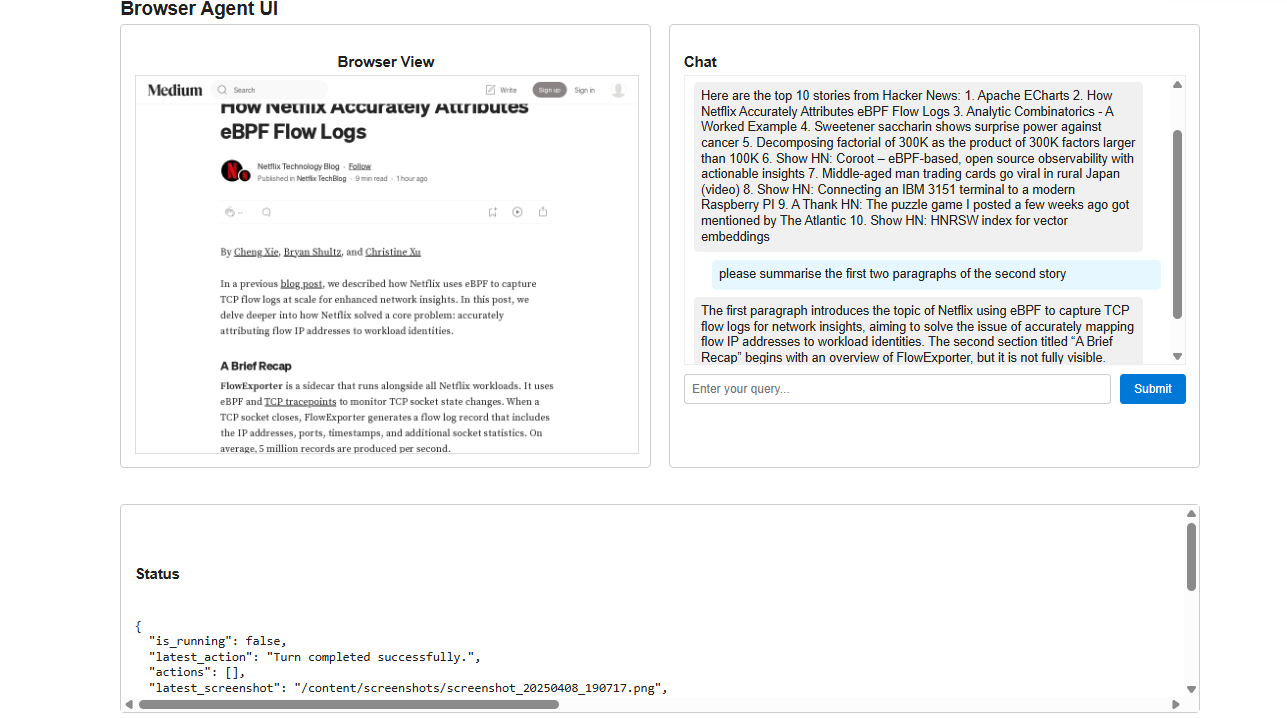

# **Connect with Me**

*   If you like this notebook or in any way found it helpful, feel free to connect with me on LinkedIn here: https://www.linkedin.com/in/james-bentley-1b329214/

# **If You Like This Please Leave A Github Star**

*   https://github.com/smartaces/OpenAI_Computer_Use_Agents_Google_Colab_Demo

# **Set Your OpenAI API Key**

To use this notebook and build your solution you will need...


*   An OpenAI user account and API Key (with billing set up)
*   As pictured below add this to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following name
*   Key name: openai_key
*   Once that is done, run the below cell link text granting key access to the notebook access if prompted




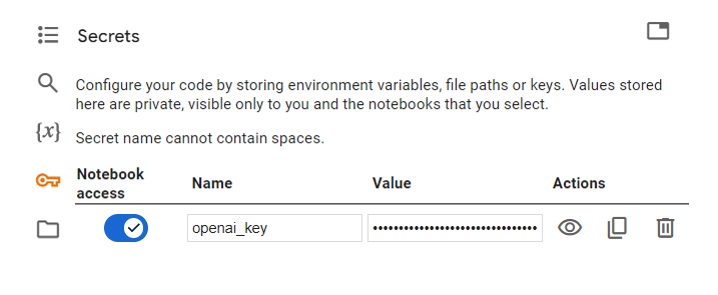


# **Important - Please Read**

Helpful guidance:

1.   Computer use agents processes text, images and actions, and can consume a lot of tokens
2.   To complete actions, the agents have to be passed historical actions as context. To make these agents work in Colab with a UI, I have had to build in ways to pass history as context. This includes the last 10 messages in the context, so potentially incurs a chunky number of tokens. Monitor your spend
3. To manage for this, I recommend keeping sessions short, or that you optimise the code more as you wish.
4. Sometimes computer use agents get stuck in loops, or act erratically, this can mean they take longer than they should to complete a simple action.
5. I have designed the notebook so that API requests and responses are logged in the **API logs folder**, the full agent history is also stored in the **conversation_history.json**, this can be useful for understanding how these agents work, and where they fail.
6. All agent screenshots are saved in the screenshots folder, again for you to check back through as you need.
7. Generally the AI works pretty well, giving you a view of the screen the agent is working on, the chat interaction history, and the current agent action/ logs.
8. This notebook uses a mix of the previous_response_id to pass historic agent actions back the computer use model, and chat history. I find this mix works best in colab, and overall it helps the agent stay on track



# **Python Package Installs**

Installs the core dependencies for running a browser automation agent in Colab.

*   playwright and playwright-stealth enable browser control with anti-detection measures
*   python-dotenv, requests, nest_asyncio, and pillow support environment config, API calls, async handling, and image processing.
*   xvfb sets up a virtual display, required to run Chromium in headless mode on Colab.

Together, these enable scripted web browsing and interaction using Playwright in a notebook environment.

In [1]:
# Install required Python packages quietly
!pip install -q playwright python-dotenv pillow requests nest_asyncio playwright-stealth

# Install Playwright browsers quietly
!playwright install chromium > /dev/null 2>&1

# Install Xvfb for headless browser support quietly
!apt-get update -qq > /dev/null
!apt-get install -y xvfb > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 35.2 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# **Setup API Keys**

Sets OpenAI API key

In [2]:

# First cell - Set up API key using userdata
from openai import OpenAI
from google.colab import userdata

openai_key = userdata.get("openai_key")
if not openai_key:
    raise ValueError("No OpenAI API key found. Please set openai_key in Colab > 'Table of contents' > 'User snippets'.")

client = OpenAI(api_key=openai_key)
print("OpenAI client initialized.")

# Also set it as an environment variable for later use
import os
os.environ["OPENAI_API_KEY"] = openai_key

OpenAI client initialized.


# **Folder Setup**

Prepares the Colab file system for the browser UI by setting up accessible paths.

*   Cleans up files and directories from any previous run to ensure a fresh start, including logs, screenshots, and browser state.
*   Then initializes a new status.json file to track the agent's state, current action, user query, and output throughout the session.   
*   Creates a /content/notebook/screenshots directory for UI access.
*   Copies the latest browser screenshot into this directory as latest.png, ensuring compatibility with Colab (avoiding unreliable symlinks).
*   Copies status.json to the notebook-accessible path for UI updates.

This allows the frontend to display the most recent screenshot and monitor agent status.

In [3]:
# Clean up previous run and set up initial state and UI access

# Remove old logs, screenshots, browser state, and history
!rm -rf api_logs playwright_state.json full_logs screenshots logs status.json conversation_history.json
!mkdir -p screenshots logs /content/notebook/screenshots

# Create a new status.json file
import json, os, glob, shutil
from google.colab import output

with open('/content/status.json', 'w') as f:
    json.dump({
        "is_running": False,
        "latest_action": "Waiting for user to submit a query...",
        "actions": [],
        "latest_screenshot": None,
        "final_output": [],
        "query": "",
        "answer": ""
    }, f)

# Copy status.json to a path accessible by the UI
!cp /content/status.json /content/notebook/status.json

# Copy the latest screenshot to a UI-accessible path (avoids symlinks)
def update_latest_screenshot_link():
    """Copy most recent screenshot to the UI-facing folder as latest.png."""
    try:
        screenshots = glob.glob("/content/screenshots/*.png")
        if screenshots:
            screenshots.sort(key=os.path.getmtime)
            latest = screenshots[-1]
            target_path = "/content/notebook/screenshots/latest.png"
            if os.path.exists(target_path):
                os.remove(target_path)
            shutil.copy2(latest, target_path)
            print(f"Copied {latest} to {target_path}")
            return True
        else:
            print("No screenshots found")
            return False
    except Exception as e:
        print(f"Error copying screenshot: {e}")
        return False

# Link latest screenshot (if exists)
update_latest_screenshot_link()


No screenshots found


False

# **Helper for Updating Agent Status**

*   Creates a small tool called update_status that helps safely change the contents of the status.json file. That file keeps track of what the browser agent is doing—like whether it's running, what step it's on, or what the final answer is.

*   Instead of rewriting the whole file every time, this function updates only the key parts. This makes sure the user interface always shows the latest information without breaking anything.

In [4]:
%%writefile status_utils.py
import os
import json

status_path = "status.json"

def update_status(**kwargs):
    """
    Safely updates the status.json file with the given key-value pairs.
    """
    if not os.path.exists(status_path):
        data = {}
    else:
        with open(status_path, "r") as f:
            try:
                data = json.load(f)
            except Exception:
                data = {}
    for k, v in kwargs.items():
        data[k] = v
    with open(status_path, "w") as f:
        json.dump(data, f, indent=2)
        f.flush()


Writing status_utils.py


# **Async Browser Control Class with Playwright**

Defines a class that manages an automated, headless browser using Playwright with stealth features.

*   It supports rich interactions like clicking, typing, scrolling, navigating, and taking screenshots. It’s designed to be used asynchronously by an AI agent that controls a browser environment.

*   Initializes a stealthy Playwright browser with custom user agent and fingerprinting to mimic real user behavior and avoid bot detection.

*   Implements browser interaction methods like click, type, scroll, goto, back, and forward, simulating human-like delays and motion.

*   Handles tab and session management, including recovery when pages close and persistence via playwright_state.json.

*   Takes and saves screenshots, optionally returning them as base64 strings for UI display or API integration.

*   Includes URL safety checks to block navigation to known malicious domains using a customizable blocklist.

In [5]:
#new version with past url attempt
%%writefile async_playwright_computer.py
import os
import json
import time
import base64
import random
import asyncio
import requests
import nest_asyncio
from typing import List, Dict
from PIL import Image
from io import BytesIO
from playwright.async_api import async_playwright
from playwright_stealth import stealth_async
from urllib.parse import urlparse

# Keyboard key mapping
CUA_KEY_TO_PLAYWRIGHT_KEY = {
    "/": "Divide",
    "\\": "Backslash",
    "alt": "Alt",
    "arrowdown": "ArrowDown",
    "arrowleft": "ArrowLeft",
    "arrowright": "ArrowRight",
    "arrowup": "ArrowUp",
    "backspace": "Backspace",
    "capslock": "CapsLock",
    "cmd": "Meta",
    "ctrl": "Control",
    "delete": "Delete",
    "end": "End",
    "enter": "Enter",
    "esc": "Escape",
    "home": "Home",
    "insert": "Insert",
    "option": "Alt",
    "pagedown": "PageDown",
    "pageup": "PageUp",
    "shift": "Shift",
    "space": " ",
    "super": "Meta",
    "tab": "Tab",
    "win": "Meta",
}

BLOCKED_DOMAINS = [
    "maliciousbook.com",
    "evilvideos.com",
    "darkwebforum.com",
    "shadytok.com",
    "suspiciouspins.com",
]

def check_blocklisted_url(url: str) -> None:
    """
    Raise ValueError if the given URL (including subdomains) is in the blocklist.
    """
    hostname = urlparse(url).hostname or ""
    if any(
        hostname == blocked or hostname.endswith(f".{blocked}")
        for blocked in BLOCKED_DOMAINS
    ):
        raise ValueError(f"Blocked URL: {url}")

class AsyncPlaywrightComputer:
    """
    Async Playwright-based computer for browser automation.
    """

    environment = "browser"
    dimensions = (1024, 768)

    def __init__(self, headless=False):
        self._playwright = None
        self._browser = None
        self._page = None
        self.headless = headless

    async def __aenter__(self):
        self._playwright = await async_playwright().start()

        # Load existing browser state if available
        storage_file = "playwright_state.json"
        context_args = {}
        if os.path.exists(storage_file):
            print("[INFO] Loading existing browser context from playwright_state.json")
            context_args["storage_state"] = storage_file

        # Launch the browser
        self._browser = await self._playwright.chromium.launch(
            headless=self.headless,
            slow_mo=50,
            args=[
                f"--window-size={self.dimensions[0]},{self.dimensions[1]}",
                "--disable-extensions",
                "--disable-blink-features=AutomationControlled"
            ]
        )

        # Create a new context with realistic browser fingerprinting
        context = await self._browser.new_context(
            viewport={"width": self.dimensions[0], "height": self.dimensions[1]},
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64; en-GB) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36",
            locale="en-GB",
            extra_http_headers={"Accept-Language": "en-GB,en;q=0.9"},
            **context_args
        )

        context.on("page", self._handle_new_page)
        self._page = await context.new_page()
        self._page.on("close", self._handle_page_close)

        # Apply stealth
        await stealth_async(self._page)

        # Network interception
        async def handle_route(route, request):
            url = request.url
            try:
                check_blocklisted_url(url)
                await route.continue_()
            except ValueError:
                print(f"Flagging blocked domain: {url}")
                await route.abort()

        await self._page.route("**/*", handle_route)

        # Navigate to last known URL, fallback to Google
        initial_url = "https://www.google.com/ncr"
        try:
            if os.path.exists("status.json"):
                with open("status.json", "r") as f:
                    status = json.load(f)
                    last_url = status.get("current_url", "")
                    if last_url.startswith("http"):
                        initial_url = last_url.strip()
        except Exception as e:
            print(f"[WARNING] Could not read last known URL from status.json: {e}")

        try:
            print(f"[INFO] Navigating to: {initial_url}")
            await self._page.goto(initial_url)
            await self._page.wait_for_load_state("networkidle", timeout=5000)
        except Exception as e:
            print(f"Initial navigation error: {e}")

        return self

    async def _handle_new_page(self, page):
        print("[INFO] New page created")
        self._page = page
        page.on("close", self._handle_page_close)

    async def _handle_page_close(self, page):
        print("[INFO] Page closed")
        if self._page == page:
            if len(self._browser.contexts) > 0 and len(self._browser.contexts[0].pages) > 0:
                self._page = self._browser.contexts[0].pages[0]
                print("[INFO] Switched to another open page")
            else:
                print("[WARNING] All pages have been closed, attempting to create a new one")
                try:
                    self._page = await self._browser.contexts[0].new_page()
                    print("[INFO] Created new page successfully")
                except Exception as e:
                    print(f"[ERROR] Failed to create new page: {e}")





    async def __aexit__(self, exc_type, exc_val, exc_tb):
        storage_file = "playwright_state.json"
        try:
            await self._browser.contexts[0].storage_state(path=storage_file)
            print(f"[INFO] Browser state saved to {storage_file}")
        except Exception as e:
            print(f"[WARNING] Could not save browser state: {e}")
        if self._browser:
            await self._browser.close()
        if self._playwright:
            await self._playwright.stop()

    async def get_current_url(self) -> str:
        return self._page.url

    async def screenshot(self, return_base64=False) -> str:
        png_bytes = await self._page.screenshot(full_page=False)
        os.makedirs("screenshots", exist_ok=True)
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        screenshot_path = f"screenshots/screenshot_{timestamp}.png"
        with open(screenshot_path, "wb") as f:
            f.write(png_bytes)
        if return_base64:
            return "data:image/png;base64," + base64.b64encode(png_bytes).decode("utf-8")
        return os.path.abspath(screenshot_path)


    # Browser action methods (click, goto, back, forward, etc.) ...
    async def click(self, x: int, y: int, button: str = "left") -> None:
        if button == "back":
            await self.back()
            return
        elif button == "forward":
            await self.forward()
            return
        elif button == "wheel":
            await self._page.mouse.wheel(x, y)
            return
        step_count = random.randint(5, 15)
        await self._page.mouse.move(x, y, steps=step_count)
        await asyncio.sleep(random.uniform(0.2, 0.8))
        button_mapping = {"left": "left", "right": "right"}
        button_type = button_mapping.get(button, "left")
        await self._page.mouse.click(x, y, button=button_type)
        try:
            await self._page.wait_for_load_state("networkidle", timeout=5000)
        except:
            pass

    async def double_click(self, x: int, y: int) -> None:
        step_count = random.randint(5, 15)
        await self._page.mouse.move(x, y, steps=step_count)
        await asyncio.sleep(random.uniform(0.2, 0.8))
        await self._page.mouse.dblclick(x, y)
        try:
            await self._page.wait_for_load_state("networkidle", timeout=5000)
        except:
            pass

    async def scroll(self, x: int, y: int, scroll_x: int, scroll_y: int) -> None:
        step_count = random.randint(3, 10)
        await self._page.mouse.move(x, y, steps=step_count)
        await asyncio.sleep(random.uniform(0.3, 0.7))
        await self._page.evaluate(f"window.scrollBy({scroll_x}, {scroll_y})")
        await asyncio.sleep(random.uniform(0.5, 1.2))

    async def type(self, text: str) -> None:
        for char in text:
            await self._page.keyboard.type(char)
            await asyncio.sleep(random.uniform(0.05, 0.25))
        await asyncio.sleep(random.uniform(0.3, 0.8))

    async def wait(self, ms: int = 1000) -> None:
        actual_ms = ms * random.uniform(0.8, 1.2)
        await asyncio.sleep(actual_ms / 1000)

    async def move(self, x: int, y: int) -> None:
        step_count = random.randint(4, 12)
        await self._page.mouse.move(x, y, steps=step_count)
        await asyncio.sleep(random.uniform(0.2, 0.5))

    async def keypress(self, keys: List[str]) -> None:
        mapped_keys = [CUA_KEY_TO_PLAYWRIGHT_KEY.get(key.lower(), key) for key in keys]

        for key in mapped_keys:
            await self._page.keyboard.down(key)
            await asyncio.sleep(random.uniform(0.03, 0.1))

        for key in reversed(mapped_keys):
            await self._page.keyboard.up(key)
            await asyncio.sleep(random.uniform(0.03, 0.1))

        await asyncio.sleep(random.uniform(0.2, 0.6))

        try:
            await self._page.wait_for_load_state("networkidle", timeout=5000)
        except:
            pass

    async def drag(self, path: List[Dict[str, int]]) -> None:
        if not path:
            return
        step_count = random.randint(5, 15)
        await self._page.mouse.move(path[0]["x"], path[0]["y"], steps=step_count)
        await asyncio.sleep(random.uniform(0.3, 0.7))
        await self._page.mouse.down()
        for point in path[1:]:
            step_count = random.randint(3, 8)
            await self._page.mouse.move(point["x"], point["y"], steps=step_count)
            await asyncio.sleep(random.uniform(0.1, 0.3))
        await self._page.mouse.up()
        await asyncio.sleep(random.uniform(0.5, 1.0))

    async def goto(self, url: str) -> None:
        try:
            if not url.startswith(("http://", "https://")):
                url = "https://" + url
            print(f"[INFO] Navigating to: {url}")
            response = await self._page.goto(url, wait_until="domcontentloaded")
            try:
                await self._page.wait_for_load_state("networkidle", timeout=10000)
            except Exception as e:
                print(f"[WARNING] Network didn't settle: {e}")
            if response and not response.ok:
                print(f"[WARNING] Page loaded with status: {response.status}")
        except Exception as e:
            print(f"[ERROR] Navigation to {url} failed: {e}")
        finally:
            await asyncio.sleep(random.uniform(1.0, 2.0))

    async def back(self) -> None:
        try:
            print("[INFO] Going back")
            await self._page.go_back(wait_until="domcontentloaded")
            try:
                await self._page.wait_for_load_state("networkidle", timeout=10000)
            except Exception as e:
                print(f"[WARNING] Network didn't settle: {e}")
        except Exception as e:
            print(f"[ERROR] Going back failed: {e}")
        finally:
            await asyncio.sleep(random.uniform(0.5, 1.5))

    async def forward(self) -> None:
        try:
            print("[INFO] Going forward")
            await self._page.go_forward(wait_until="domcontentloaded")
            try:
                await self._page.wait_for_load_state("networkidle", timeout=10000)
            except Exception as e:
                print(f"[WARNING] Network didn't settle: {e}")
        except Exception as e:
            print(f"[ERROR] Going forward failed: {e}")
        finally:
            await asyncio.sleep(random.uniform(0.5, 1.5))

    # Other actions (double_click, scroll, type, etc.) can remain the same...


Writing async_playwright_computer.py


# **Async Agent for Multi-Step Browser Interaction (async_agent.py)**

This script defines an AsyncAgent that connects an OpenAI model with a browser automation environment, enabling it to carry out complex, multi-step tasks through iterative API calls.

*   Maintains conversation flow and memory using previous_response_id, allowing the agent to build on previous interactions.

*   Executes model-suggested actions like browser navigation, clicks, and typing, then sends screenshots and feedback back to the model.

*   Logs all API requests and responses for debugging, and includes detailed error handling with automatic retries and recovery steps.

*   Supports safety checks to confirm user consent and blocks known malicious websites before performing browser actions.

*   Runs a loop (run_full_turn) that continues processing until the agent completes its task or encounters an unrecoverable error.

In [6]:
#New Version
%%writefile async_agent.py
import os
import json
import time
import random
import asyncio
import requests
from typing import List, Dict, Optional # Added Optional
# Ensure AsyncPlaywrightComputer is imported correctly if used for type hints
try:
    from async_playwright_computer import check_blocklisted_url, AsyncPlaywrightComputer
except ImportError:
    # Define a placeholder if the import fails, to avoid NameError
    class AsyncPlaywrightComputer: pass
    def check_blocklisted_url(url: str): pass # Placeholder function
    print("[Warning] async_playwright_computer parts not imported, using placeholders.")

from urllib.parse import urlparse
from status_utils import update_status  # continuous status updates

def pp(obj):
    """Pretty prints a Python object as JSON."""
    # Handle potential non-serializable data if necessary
    try:
        print(json.dumps(obj, indent=4, default=str)) # Use default=str for safety
    except TypeError:
        print(f"[ERROR] Could not serialize object for pretty printing: {obj}")


def sanitize_message(msg: dict) -> dict:
    """Removes potentially large fields like image_url for cleaner logging."""
    if not isinstance(msg, dict): return msg # Handle non-dict inputs
    if msg.get("type") == "computer_call_output":
        output = msg.get("output", {})
        # Check if output is a dict and has image_url before copying
        if isinstance(output, dict) and "image_url" in output:
            sanitized = msg.copy()
            sanitized["output"] = output.copy()
            # Only include image_url field if it exists
            if "image_url" in sanitized["output"]:
                sanitized["output"]["image_url"] = "[omitted]"
            return sanitized
    # Return original message if no sanitization needed or format unexpected
    return msg

# --- MODIFIED create_response ---
def create_response(previous_response_id: Optional[str] = None, **kwargs):
    """
    Creates a response using the OpenAI Responses API, optionally linking to a previous response.
    Raises ValueError on API errors.
    """
    url = "https://api.openai.com/v1/responses"
    headers = {
        "Authorization": f"Bearer {os.environ.get('OPENAI_API_KEY','')}",
        "Content-Type": "application/json"
    }
        # Prepare the payload, starting with kwargs
    payload = kwargs.copy()

    # Explicitly set tool_choice behavior
    payload["tool_choice"] = "auto"  # or "required"


    # Add previous_response_id if it's provided
    if previous_response_id:
        payload["previous_response_id"] = previous_response_id

    # Logging Request
    os.makedirs("api_logs", exist_ok=True)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    request_file = f"api_logs/request_{timestamp}_{'linked' if previous_response_id else 'initial'}.json"
    with open(request_file, "w") as f:
        # Log the full payload being sent
        json.dump(payload, f, indent=2, default=str) # Use default=str for safety

    # Make the API call
    response = requests.post(url, headers=headers, json=payload)
    response_data = {}
    try:
        response_data = response.json()
    except json.JSONDecodeError:
        # Include status code in the error message if JSON decoding fails
        response_data = {"error": f"Failed to decode JSON (Status: {response.status_code}): {response.text}", "status_code": response.status_code}


    # Add status code if not present in JSON error (though it should be after above change)
    if response.status_code != 200 and 'status_code' not in response_data:
         response_data['status_code'] = response.status_code

    # Logging Response
    response_file = f"api_logs/response_{timestamp}.json"
    with open(response_file, "w") as f:
        json.dump(response_data, f, indent=2, default=str) # Use default=str

    print(f"[LOG] Request saved to {request_file}")
    print(f"[LOG] Response saved to {response_file}")

    # --- More robust error handling and ID extraction ---
    if response.status_code != 200:
        error_content = response_data.get("error", "Unknown API Error")
        # Try to extract more specific error message if error content is structured
        if isinstance(error_content, dict) and "message" in error_content:
             error_message = error_content["message"]
        elif isinstance(error_content, str):
             error_message = error_content
        else:
             error_message = str(error_content)

        print(f"Error: {response.status_code} {error_message}")
        # Raise exception to be caught by the main loop's error handling
        raise ValueError(f"API Error {response.status_code}: {error_message}")

    # Ensure the response ID is captured for linking
    if 'id' not in response_data:
        # Check common headers if ID is missing from body (adjust header names as needed)
        header_id = response.headers.get('openai-response-id') or response.headers.get('X-Request-ID')
        if header_id:
           response_data['id'] = header_id
           print(f"[INFO] Found response ID in headers: {header_id}")
        else:
           print("[WARNING] Response ID not found in API response body or headers.")
           response_data['id'] = None # Set explicitly to None if missing
    # --- End modification ---

    return response_data

class AsyncAgent:
    def __init__(
        self,
        model="computer-use-preview",
        computer: Optional[AsyncPlaywrightComputer] = None, # Type hint for clarity
        tools: Optional[List[Dict]] = None, # Type hint
        acknowledge_safety_check_callback=None,
    ):
        self.model = model
        self.computer = computer
        # Ensure self.tools is always a list
        self.tools = tools if tools is not None else []
        self.print_steps = True
        self.debug = False
        self.show_images = False # Note: Images won't show in Colab output easily if headless
        self.acknowledge_safety_check_callback = acknowledge_safety_check_callback or (lambda message: True)

        # Define navigation tools (can be extended)
        navigation_tools = [
            {
                "type": "function",
                "name": "back",
                "description": "Go back to the previous page.",
                "parameters": {},
            },
            {
                "type": "function",
                "name": "goto",
                "description": "Go to a specific URL.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "Fully qualified URL to navigate to (e.g., https://www.google.com).",
                        },
                    },
                    "additionalProperties": False,
                    "required": ["url"],
                },
            },
            {
                 "type": "function",
                 "name": "forward",
                 "description": "Go forward to the next page.",
                 "parameters": {},
             },
        ]
        # Combine provided tools with navigation tools, avoiding duplicates
        nav_tool_names = {t['name'] for t in navigation_tools}
        filtered_existing_tools = [t for t in self.tools if t.get('name') not in nav_tool_names]
        self.tools = navigation_tools + filtered_existing_tools


        # Add computer tool if a computer environment is provided
        if computer:
            # Ensure computer tool is not added twice if already in self.tools
            # Use the type name expected by the API - VERIFY THIS
            computer_tool_type = "computer_use_preview" # Defaulting based on docs
            if not any(t.get("type") == computer_tool_type for t in self.tools):
                 self.tools.append(
                    {
                        "type": computer_tool_type,
                        "display_width": computer.dimensions[0],
                        "display_height": computer.dimensions[1],
                        "environment": computer.environment, # e.g., "browser", "mac", "windows", "ubuntu"
                    }
                )
        print(f"[INFO] Agent initialized with tools: {[t.get('type') or t.get('name') for t in self.tools]}")


    def debug_print(self, *args):
        """Prints debug information if self.debug is True."""
        if self.debug:
            for arg in args:
                # Use sanitize_message for logging potentially large API data
                try:
                    if isinstance(arg, (list, dict)):
                         sanitized_arg = sanitize_message(arg) if isinstance(arg, dict) else [sanitize_message(m) for m in arg]
                         pp(sanitized_arg)
                    else:
                         print(arg)
                except Exception as e:
                    print(f"[DEBUG PRINT ERROR] Could not process arg: {e}")


    async def handle_item(self, item: Dict) -> List[Dict]:
        """
        Handles a single item from the API response (e.g., executes a computer call).
        Returns a list of new items to be added to the conversation (e.g., computer_call_output).
        """
        new_items = [] # Items generated by handling this specific item
        item_type = item.get("type") # Get type upfront
        call_id_for_error = f"error_recovery_{time.time()}"

        try:
            if item_type == "message" or item_type == "output_text": # Handle potential variations
                content = item.get("content", [])
                # Check if content is a list and has the expected structure
                if content and isinstance(content, list) and len(content) > 0 and content[0].get("type") == "output_text":
                    text_content = content[0].get("text", "")
                    if self.print_steps and text_content:
                        print(f"[Assistant] {text_content}")
                elif self.print_steps: # Log even if format is unexpected
                     print(f"[Assistant Message - format unexpected] {item}")


            elif item_type == "function_call":
                name = item.get("name")
                args_str = item.get("arguments", "{}")
                call_id = item.get("call_id")
                if not name or not call_id:
                     print(f"[ERROR] Malformed function_call item: {item}")
                     return [] # Skip malformed item

                try:
                    args = json.loads(args_str)
                except json.JSONDecodeError:
                    print(f"[ERROR] Invalid JSON arguments for function {name}: {args_str}")
                    return [{ # Return error output
                        "type": "function_call_output",
                        "call_id": call_id,
                        "output": f"Error: Invalid JSON arguments provided: {args_str}",
                    }]

                if self.print_steps:
                    print(f"[Action] Function Call: {name}({args})")

                output_content = f"Error: Computer object not available or function '{name}' not found."
                if self.computer and hasattr(self.computer, name): # Check if computer exists
                    method = getattr(self.computer, name)
                    try:
                        await method(**args)
                        output_content = "success"
                        print(f"[INFO] Function {name} executed successfully.")
                    except Exception as func_exc:
                        print(f"[ERROR] Executing function {name} failed: {func_exc}")
                        # Optionally include traceback for debugging
                        # import traceback
                        # traceback.print_exc()
                        output_content = f"Error executing function {name}: {func_exc}"
                elif not self.computer:
                     output_content = "Error: Computer object not configured."
                     print(f"[ERROR] {output_content}")
                else: # computer exists but function doesn't
                     print(f"[WARNING] Function '{name}' not found on computer object.")
                     output_content = f"Error: Function '{name}' not found."


                new_items.append({
                    "type": "function_call_output",
                    "call_id": call_id,
                    "output": output_content,
                })

            elif item_type == "computer_call":
                action = item.get("action", {})
                action_type = action.get("type")
                action_args = {k: v for k, v in action.items() if k != "type"}
                call_id = item.get("call_id")

                if not action_type or not call_id or not self.computer:  # Check computer exists
                    error_msg = f"Invalid computer_call item (action_type={action_type}, call_id={call_id}) or missing computer object."
                    print(f"[ERROR] {error_msg}")
                    return [{
                        "type": "computer_call_output",
                        "call_id": call_id or "unknown_call",
                        "output": {"error": error_msg},
                        "acknowledged_safety_checks": item.get("pending_safety_checks", [])
                    }]

                if self.print_steps:
                    print(f"[Action] Computer Call: {action_type}({action_args})")

                if not hasattr(self.computer, action_type):
                    error_msg = f"Computer action '{action_type}' not implemented."
                    print(f"[ERROR] {error_msg}")
                    return [{
                        "type": "computer_call_output",
                        "call_id": call_id,
                        "output": {"error": error_msg},
                        "acknowledged_safety_checks": item.get("pending_safety_checks", []),
                    }]

                # Execute the computer action
                method = getattr(self.computer, action_type)
                await method(**action_args)
                await asyncio.sleep(random.uniform(0.5, 1.5))  # Short random delay

                # Screenshot after action
                file_path = await self.computer.screenshot()
                base64_url = await self.computer.screenshot(return_base64=True)

                # Get and store current browser URL
                current_url = None
                if self.computer.environment == "browser":
                    try:
                        current_url = await self.computer.get_current_url()
                    except Exception as e:
                        print(f"[WARNING] Could not get current URL: {e}")

                update_status(latest_screenshot=file_path, current_url=current_url)

                # Handle safety checks
                pending_checks = item.get("pending_safety_checks", [])
                acknowledged_checks = []
                if pending_checks:  # Process only if there are checks
                    for check in pending_checks:
                        message = check.get("message", "Unknown safety check message")
                        if self.acknowledge_safety_check_callback(message):
                            acknowledged_checks.append(check)
                            print(f"[Safety Check] Acknowledged: {message[:50]}...")
                        else:
                            print(f"[Safety Check] Denied: {message[:50]}...")
                            raise ValueError(f"Safety check denied by callback: {message}")
                else:
                    if self.debug:
                        print("[DEBUG] No pending safety checks.")





                # Prepare the output payload for the API
                call_output_payload = {
                    "type": "input_image",
                    "image_url": base64_url,
                }

                # Add current URL if in browser environment
                if self.computer.environment == "browser":
                    current_url = await self.computer.get_current_url()
                    try:
                        check_blocklisted_url(current_url)
                        call_output_payload["current_url"] = current_url
                    except ValueError as e:
                        # Blocked URL - raise to stop the process
                        raise ValueError(f"Blocked URL accessed: {current_url}. Aborting.") from e

                # Construct the computer_call_output message
                computer_output_item = {
                    "type": "computer_call_output",
                    "call_id": call_id,
                    "acknowledged_safety_checks": acknowledged_checks,
                    "output": call_output_payload,
                }
                new_items.append(computer_output_item)
                print(f"[INFO] Handled computer_call {action_type}, returning output for call_id {call_id}")


            elif item_type == "reasoning":
                 if self.print_steps and "summary" in item and item["summary"]:
                      # Check summary structure before accessing
                      if isinstance(item["summary"], list) and len(item["summary"]) > 0 and "text" in item["summary"][0]:
                           print(f"[Reasoning] {item['summary'][0]['text']}")
            # Add handling for other potential item types if needed

            # --- Handle error recovery trigger (if used) ---
            elif item_type == "error_recovery":
                # This type is added internally on exception, log and potentially screenshot
                print(f"[INFO] Handling internal error recovery trigger. Context: {item.get('error_context')}")
                # Fall through to the general exception handler's screenshot logic below if needed
                # Or directly attempt screenshot here if the structure allows
                raise RuntimeError(f"Internal error recovery triggered: {item.get('error_context')}") # Force into exception handler


        except Exception as e:
            # --- Centralized Exception Handling for handle_item ---
            print(f"[ERROR] Exception during handle_item (item_type='{item_type}'): {e}")
            # import traceback # Uncomment for detailed stack trace during debugging
            # traceback.print_exc()

            # Attempt to generate a recovery screenshot
            try:
                # Check computer state before attempting screenshot
                if self.computer and hasattr(self.computer, '_page') and self.computer._page and not self.computer._page.is_closed():
                    print("[INFO] Attempting recovery screenshot...")
                    file_path = await self.computer.screenshot()
                    base64_url = await self.computer.screenshot(return_base64=True)
                    update_status(latest_screenshot=file_path)

                    error_output_payload = {
                         "type": "input_image",
                         "image_url": base64_url,
                         "error_message": f"Error processing step type '{item_type}': {e}"
                    }
                    # Add URL if possible
                    if self.computer.environment == "browser":
                         try:
                              error_output_payload["current_url"] = await self.computer.get_current_url()
                         except Exception: pass # Ignore error getting URL during error handling

                    error_output = {
                        "type": "computer_call_output", # Use standard type for model input
                        "call_id": call_id_for_error, # Use call_id from item if available
                        "output": error_output_payload,
                        "acknowledged_safety_checks": [],
                    }
                    new_items.append(error_output)
                    print(f"[INFO] Added error recovery screenshot for context: {item_type}")
                else:
                     # Computer state doesn't allow screenshot
                     print("[WARNING] Computer state invalid for recovery screenshot.")
                     new_items.append({
                         "type": "computer_call_output",
                         "call_id": call_id_for_error,
                         "output": {"error": f"Error processing step type '{item_type}' ({e}), and unable to get recovery screenshot."},
                         "acknowledged_safety_checks": [],
                     })

            except Exception as recovery_error:
                print(f"[ERROR] Could not capture recovery screenshot after error: {recovery_error}")
                # Append a simpler error message if screenshot fails
                new_items.append({
                    "type": "computer_call_output",
                    "call_id": call_id_for_error,
                    "output": {"error": f"Error processing step type '{item_type}' ({e}), and failed to get recovery screenshot ({recovery_error})."},
                     "acknowledged_safety_checks": [],
                })

        return new_items

    # --- REVISED run_full_turn with improved loop logic ---
    async def run_full_turn(self, input_items: List[Dict], print_steps=True, debug=False, show_images=False):
        """
        Runs a full turn of the agent using previous_response_id, continuing as long as actions are requested.
        Returns a list of all messages generated *during this turn*.
        """
        self.print_steps = print_steps
        self.debug = debug
        self.show_images = show_images

        items_generated_this_turn = [] # Accumulate ALL items for the final return value
        last_response_id = None        # Track the ID of the last API response
        is_first_request = True        # Flag for the initial API call
        items_for_next_request = []    # Holds ONLY the input items for the *next* linked API call

        progress_log = []
        max_retries = 3
        retry_count = 0
        update_status(is_running=True, latest_action="Starting agent turn...")

        while True: # Loop indefinitely until explicitly broken by logic inside
            try:
                # --- Prepare API Input ---
                api_input_data = []
                if is_first_request:
                    # Send the initial context (e.g., system prompt + user query)
                    api_input_data = list(input_items)
                else:
                    # Send only the results from the previous step(s) handled by handle_item
                    api_input_data = items_for_next_request
                    if not api_input_data:
                         print("[INFO] No specific input data generated from previous step. Ending turn likely.")
                         # This might be normal if the previous step was just an assistant message.
                         # We rely on the response check below to confirm if actions are needed.
                         # However, if the previous step was an action expecting output, this indicates an issue.
                         # Let the loop proceed to API call, which might return the final answer or error.


                if self.debug:
                     print("\n--- Preparing API Request ---")
                     print(f"Is First Request: {is_first_request}")
                     print(f"Using Previous Response ID: {last_response_id}")
                     print("Input Data for API (Sanitized):")
                     self.debug_print(api_input_data)

                # --- Call API ---
                response = create_response(
                    model=self.model,
                    input=api_input_data,
                    tools=self.tools,
                    truncation="auto", # Ensure truncation is enabled
                    previous_response_id=last_response_id # Pass the ID
                )
                if self.debug:
                     print("\n--- Received API Response ---")
                     self.debug_print(response) # Log sanitized response

                # --- Process Response ---
                last_response_id = response.get("id")  # Store the new ID for the *next* iteration
                is_first_request = False               # No longer the first request
                items_for_next_request = []            # Reset items for the *next* input payload

                current_response_id_str = str(last_response_id)[:8] if last_response_id else "N/A"
                progress_log.append(f"Received response ID: {current_response_id_str}")
                update_status(latest_action=f"Processed API response {current_response_id_str}...", progress_log=progress_log)

                response_output = response.get("output")
                if not response_output:
                    print("[INFO] Model returned empty output list. Assuming turn completion.")
                    break  # Exit the loop

                # --- Track expected call_ids for validation ---
                expected_call_ids = {
                    item.get("call_id") for item in response_output
                    if item.get("type") in ("computer_call", "function_call")
                }

                # --- Iterate through response items, execute actions, prepare next input ---
                # *** MODIFIED LOGIC: Check if ANY action is requested in this response ***
                action_requested_in_this_response = False
                for item in response_output:
                    # Accumulate ALL items for the function's final return value (full log)
                    items_generated_this_turn.append(item)
                    # Check if this item is an action call BEFORE handling it
                    item_type = item.get("type")
                    if item_type == "computer_call" or item_type == "function_call":
                        action_requested_in_this_response = True

                    # Handle the item (executes actions, generates outputs like computer_call_output)
                    additional_items = await self.handle_item(item)

                    # Accumulate results for the function's return value
                    items_generated_this_turn.extend(additional_items)
                    # Only add the *results* (outputs from handle_item) to the input for the next API call
                    items_for_next_request.extend(additional_items)
                # --- End processing all items for this response ---


                # --- Loop Control Logic (Revised) ---
                if not action_requested_in_this_response:
                    # If this specific response from the API had no computer or function calls,
                    # it means the model did not request further state changes or interactions.
                    # Assume the agent is done or has provided a final text response.
                    print("[INFO] No further 'computer_call' or 'function_call' requested in the latest API response. Ending turn.")
                    break # Exit the loop
                else:
                    # If actions were requested, reset retry count and continue loop for the next step
                    print("[INFO] Actions requested. Continuing agent turn...")
                    retry_count = 0

            except Exception as e:
                # --- Error Handling within the loop ---
                retry_count += 1
                # Log detailed error
                import traceback
                error_trace = traceback.format_exc()
                error_msg = f"[ERROR] Agent loop failed (attempt {retry_count}/{max_retries}): {e}\n{error_trace}"
                print(error_msg)
                progress_log.append(f"ERROR attempt {retry_count}: {e}") # Keep log concise
                update_status(latest_action=f"Error attempt {retry_count}: {e}", progress_log=progress_log)


                if retry_count >= max_retries:
                    print("[FATAL] Maximum retries exceeded.")
                    # Add a final error message to the returned items
                    items_generated_this_turn.append({
                        "role": "assistant", # Use assistant role for final message
                        "content": [{"type": "output_text", "text": f"I encountered an unrecoverable error after {max_retries} attempts: {e}. Please check logs and try again later."}]
                    })
                    progress_log.append("Maximum retries exceeded. Ending turn.")
                    # Ensure status is updated to non-running on fatal error
                    update_status(latest_action="Turn ended due to maximum retries", is_running=False, progress_log=progress_log)
                    break # Exit the loop

                # Wait before retry
                await asyncio.sleep(random.uniform(1.5, 3.0))

                # --- Retry Logic ---
                print(f"[INFO] Attempting retry ({retry_count}/{max_retries}) after error...")
                # Attempt recovery screenshot and prepare for retry by adding it to items_for_next_request
                try:
                     # Pass error context to handle_item's internal recovery logic
                     recovery_output_items = await self.handle_item({"type": "error_recovery", "error_context": str(e)})
                     items_generated_this_turn.extend(recovery_output_items)
                     items_for_next_request.extend(recovery_output_items) # Send recovery state back to model
                     # Decide how to handle linking on retry. Resetting ID might be safer.
                     print("[INFO] Resetting previous_response_id for retry.")
                     last_response_id = None
                     # Let the loop continue; items_for_next_request now contains the recovery output.
                     # is_first_request remains False, so only recovery items are sent.

                except Exception as retry_prep_error:
                     print(f"[ERROR] Failed to prepare for retry (e.g. recovery screenshot): {retry_prep_error}")
                     # If even preparing for retry fails, break the loop.
                     items_generated_this_turn.append({
                        "role": "assistant",
                        "content": [{"type": "output_text", "text": f"Error during retry preparation after initial error ({e}): {retry_prep_error}. Aborting turn."}]
                     })
                     update_status(latest_action="Turn ended due to retry preparation error", is_running=False, progress_log=progress_log)
                     break # Exit loop


        # --- Final Status Update ---
        # Ensure status is updated correctly on loop exit (normal or error break)
        final_status_update = {"is_running": False}
        # Find the very last message in the generated items
        last_msg = items_generated_this_turn[-1] if items_generated_this_turn else None
        if last_msg and last_msg.get("role") == "assistant" and last_msg.get("content"):
            try: # Safely access potentially nested text
                final_text = last_msg["content"][0].get("text", "(empty)")[:100]
                final_status_update["latest_action"] = f"Turn ended. Final message: {final_text}..."
            except (IndexError, KeyError, TypeError):
                final_status_update["latest_action"] = "Turn ended. (Could not parse final message)"
        elif retry_count >= max_retries:
             # Already handled in retry logic, but double-check
             final_status_update["latest_action"] = "Turn ended due to maximum retries."
        else:
            final_status_update["latest_action"] = "Turn completed or stopped."

        update_status(**final_status_update)
        print(f"[INFO] {final_status_update['latest_action']}")

        # Return the comprehensive list of all items generated during this specific turn
        return items_generated_this_turn

Writing async_agent.py


# **Browser Agent Background Process (cua_browser_bg.py)**

Description:
This script runs the browser-based AI agent in the background, managing a full conversation turn in response to a user query. It sets up the browser, loads conversation history, and coordinates between the agent and the browser environment.

*   Launches a virtual display (Xvfb) so Playwright can run in headless mode on Colab.

*   Wraps the browser environment in a custom class that updates status whenever a screenshot is taken.

*   Loads conversation history and adds the new user query, ensuring the agent has full context.

*   Initializes the agent with a system prompt and runs a full interaction loop using run_full_turn, executing all steps the model requests.

*   Saves the updated conversation history and updates the UI-facing status file with the latest output, screenshot, and logs.

In [7]:
%%writefile cua_browser_bg.py
import os
import json
import asyncio
import time
import sys
import nest_asyncio
import subprocess
import glob

# Assume these files exist in the same directory or are importable
from async_playwright_computer import AsyncPlaywrightComputer
from async_agent import AsyncAgent
from status_utils import update_status

status_path = "status.json"
conversation_history_path = "conversation_history.json" # Define the history file path

class StatusUpdatingComputer(AsyncPlaywrightComputer):
    """ Custom computer class to update status on screenshot """
    async def screenshot(self, return_base64=False) -> str:
        screenshot_result = await super().screenshot(return_base64=return_base64)
        if not return_base64:
            update_status(latest_screenshot=screenshot_result)
        return screenshot_result

def acknowledge_safety_check_callback(message: str) -> bool:
    print(f"[Safety Check] {message}")
    return True

async def run_single_turn(query):
    xvfb_cmd = ["Xvfb", ":99", "-screen", "0", "1280x800x24", "-nolisten", "tcp"]
    xvfb_proc = subprocess.Popen(xvfb_cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    os.environ["DISPLAY"] = ":99"
    print("[INFO] Xvfb started.")

    try:
        async with StatusUpdatingComputer(headless=True) as computer:
            update_status(is_running=True, latest_action="Browser launched and ready", query=query, final_output=[])
            print("[INFO] Playwright Computer initialized.")

            agent = AsyncAgent(
                model="computer-use-preview",
                computer=computer,
                acknowledge_safety_check_callback=acknowledge_safety_check_callback
            )
            print("[INFO] Agent initialized.")

            system_message = {
                "role": "system",
                "content": """
                You are a helpful assistant that can browse the web using the provided tools.
                You have access to these navigation functions:
                1. goto(url) - Navigate directly to a URL
                2. back() - Go back to the previous page
                3. forward() - Go forward to the next page

                The browser starts on Google's search page by default.

                NAVIGATION GUIDELINES:
                - For direct website navigation: ALWAYS use goto() (e.g., goto('https://news.ycombinator.com/'))
                - To return to previous pages: ALWAYS use back()
                - To go forward to a page after going back: ALWAYS use forward()

                CONTINUATION ACTIONS
                - Assess the users question, and determine if it is a continuation action, in a series of related actions or a completely new and unrelated action
                - If it is a continuation action determine if you can continue it from the current webpage url you are supplied with, and where apporpriate do that

                CONTEXT SWITCHING GUIDELINES:
                - When a user asks for information that is NOT related to the current page, ALWAYS start a new Google search
                - To start a new Google search: use goto('https://www.google.com')
                - Examples of context switches requiring a new search:
                  * You're on Tower of London website and user asks about McDonald's
                  * You're on a news site and user asks about weather

                NAVIGATION WITHIN SAME CONTEXT:
                - When exploring multiple pages on the same website (e.g., different Hacker News stories):
                  * Use click() to navigate to specific content
                  * Use back() to return to previous pages on the same site

                INTERACTION GUIDELINES:
                - For Google searches: Use the search box directly with click and type operations
                - For cookie banners, popups, and other UI elements: Use normal UI interactions (click)
                - For scrolling, clicking links, filling forms: Use normal computer interactions

                KEYBOARD SHORTCUTS:
                - Use keypress(['ctrl', 'r']) to refresh a page
                - Use keypress(['ctrl', 'l']) to focus the address bar
                - Use keypress(['enter']) to submit forms or proceed

                This approach ensures reliable navigation between sites while allowing normal interaction with page content.
                Always provide a final textual answer to the user's query based on your browsing.
                """
            }

            # --- Load/Initialize Conversation History ---
            conversation = []
            if os.path.exists(conversation_history_path):
                try:
                    with open(conversation_history_path, "r") as f:
                        conversation = json.load(f)
                    if not isinstance(conversation, list):
                        print(f"[WARNING] Invalid conversation history found in {conversation_history_path}. Starting fresh.")
                        conversation = []
                    else:
                        print(f"[INFO] Loaded {len(conversation)} items from conversation history.")
                except json.JSONDecodeError:
                    print(f"[WARNING] Could not decode {conversation_history_path}. Starting fresh.")
                    conversation = []
                except Exception as e:
                    print(f"[ERROR] Error loading conversation history: {e}. Starting fresh.")
                    conversation = []

            if not conversation or conversation[0].get("role") != "system":
                print("[INFO] Initializing conversation history with system prompt.")
                conversation = [system_message]

            # --- Inject last known URL (for context) ---
            try:
                with open(status_path, "r") as f:
                    status_data = json.load(f)
                last_url = status_data.get("latest_screenshot", "")
                current_url = status_data.get("latest_action", "").replace("Turn ended. Final message:", "").strip()
                if "http" in current_url:
                    conversation.append({
                        "role": "system",
                        "content": f"Note: You were last on {current_url}. Only navigate to Google if this page is no longer relevant."
                    })
                    print(f"[INFO] Injected last known URL context: {current_url}")
            except Exception as e:
                print(f"[WARNING] Could not inject last known URL: {e}")

            # --- Append Current User Query ---
            if query:
                recent = conversation[-3:]
                tool_in_progress = any(
                    item.get("type") in ("computer_call", "function_call") and item.get("status") != "completed"
                    for item in recent
                )
                if not tool_in_progress:
                    conversation.append({"role": "user", "content": query})
                    print(f"[INFO] Appended current user query: '{query[:50]}...'")
                else:
                    print("[INFO] Tool call in progress — delaying user message injection.")
                    return

            update_status(latest_action=f"Starting agent turn for query: {query[:50]}...")
            print("[INFO] Starting agent full turn...")

            N = 10
            messages_to_send = [conversation[0]] if conversation[0].get("role") == "system" else []
            messages_to_send += conversation[-N:]

            response_items = await agent.run_full_turn(
                messages_to_send,
                print_steps=True,
                debug=False,
                show_images=False
            )
            print("[INFO] Agent full turn completed.")

            conversation.extend(response_items)
            print(f"[INFO] Appended {len(response_items)} response items to conversation history.")

            try:
                with open(conversation_history_path, "w") as f:
                    json.dump(conversation, f, indent=2)
                print(f"[INFO] Conversation history saved to {conversation_history_path}")
            except Exception as e:
                print(f"[ERROR] Failed to save conversation history: {e}")

            final_text = "(No final textual response received for this turn)"
            if response_items and response_items[-1].get("role") == "assistant":
                content_list = response_items[-1].get("content", [])
                if content_list and isinstance(content_list, list) and len(content_list) > 0:
                   if "text" in content_list[0]:
                       final_text = content_list[0]["text"]
                       print(f"[INFO] Extracted final text: {final_text[:100]}...")

            try:
                log_files = sorted(glob.glob("api_logs/request_*.json"))
                latest_log_file = log_files[-1] if log_files else None
            except Exception as log_e:
                print(f"[WARNING] Could not determine latest log file: {log_e}")
                latest_log_file = None

            update_status(
                is_running=False,
                final_output=[final_text],
                latest_log_file=latest_log_file,
                latest_action="Turn completed successfully."
            )
            print("[INFO] Final status updated.")

    except Exception as e:
        error_message = f"An error occurred during the turn: {e}"
        print(f"[FATAL ERROR] {error_message}")
        update_status(
            is_running=False,
            final_output=[f"Error: {e}"],
            latest_action=error_message
        )
    finally:
        xvfb_proc.terminate()
        xvfb_proc.wait()
        print("[INFO] Xvfb terminated.")

def main():
    nest_asyncio.apply()

    if not os.path.exists(status_path):
        print(f"[WARNING] {status_path} not found. Initializing.")
        update_status(query="", is_running=False, final_output=[])

    query = ""
    try:
        with open(status_path, "r") as f:
            st = json.load(f)
        query = st.get("query", "")
        if not query:
            print("[INFO] No query found in status.json. Exiting.")
            update_status(is_running=False, latest_action="No query provided.")
            return
    except Exception as e:
        print(f"[ERROR] Could not load query from {status_path}: {e}")
        update_status(is_running=False, latest_action=f"Error loading status: {e}")
        return

    print(f"[INFO] Starting background process for query: {query[:50]}...")
    asyncio.run(run_single_turn(query))
    print("[INFO] Background process finished.")

if __name__ == "__main__":
    main()

Writing cua_browser_bg.py


# **Colab Callbacks for Running Browser Agent**

This script registers two functions as Colab output callbacks to connect the frontend (UI) with the backend browser agent.

*   get_status_json() reads and returns the current agent status from status.json so the UI can display real-time updates.

*   run_cua_browser(query) writes the user query to status.json and launches the browser agent script (cua_browser_bg.py) in the background using xvfb-run for headless execution.

*   These callbacks allow the HTML/JS interface to trigger the agent and fetch live updates through google.colab.output.

In [8]:
import os
import json
import sys
import subprocess
from google.colab import output

status_path = "status.json"

def get_status_json():
    """
    Returns contents of status.json as a Python dict (which Colab auto-converts to JSON).
    """
    try:
        with open(status_path, "r") as f:
            return json.load(f)
    except:
        return {}

def run_cua_browser(query):
    """
    Writes `query` to status.json and spawns cua_browser_bg.py (headless) in the background.
    """
    # Load or create status
    try:
        with open(status_path, "r") as f:
            data = json.load(f)
    except:
        data = {}

    data["is_running"] = True
    data["query"] = query
    data["final_output"] = []
    data["latest_screenshot"] = None

    with open(status_path, "w") as f:
        json.dump(data, f, indent=2)

    cmd = f'OPENAI_API_KEY="{os.environ.get("OPENAI_API_KEY","")}" xvfb-run {sys.executable} /content/cua_browser_bg.py'
    subprocess.Popen(cmd, shell=True)

output.register_callback('get_status_json', get_status_json)
output.register_callback('run_cua_browser', run_cua_browser)

print("Callbacks registered: get_status_json, run_cua_browser")


Callbacks registered: get_status_json, run_cua_browser


# **Simple UI**

Creates a simple UI

*   Image preview pane to see most recent browser image

*   Chat history

*   A view of api calls/ actions below

In [9]:
%%writefile browser_agent_ui.html
<!DOCTYPE html>
<html>
<head>
  <style>
    body {
      font-family: Arial, sans-serif;
      margin: 20px;
    }
    .container {
      max-width: 1200px;
      margin: 0 auto;
    }
    .panel {
      border: 1px solid #ccc;
      border-radius: 5px;
      padding: 15px;
      margin-bottom: 20px;
    }
    .screenshot-panel {
      text-align: center;
    }
    .screenshot-image {
      max-width: 100%;
      max-height: 500px;
      border: 1px solid #ddd;
    }
    .placeholder {
      width: 100%;
      height: 300px;
      background: #f0f0f0;
      display: flex;
      align-items: center;
      justify-content: center;
      color: #888;
    }
    .chat-panel {
      display: flex;
      flex-direction: column;
    }
    .message-container {
      overflow-y: auto;
      max-height: 300px;
      border: 1px solid #eee;
      padding: 10px;
      margin-bottom: 10px;
    }
    .message {
      margin-bottom: 8px;
      padding: 8px;
      border-radius: 5px;
    }
    .user-message {
      background-color: #e6f7ff;
      margin-left: 20px;
    }
    .agent-message {
      background-color: #f0f0f0;
      margin-right: 20px;
    }
    .input-row {
      display: flex;
      gap: 10px;
    }
    input[type="text"] {
      flex-grow: 1;
      padding: 8px;
      border: 1px solid #ccc;
      border-radius: 4px;
    }
    button {
      padding: 8px 16px;
      background-color: #0078D7;
      color: white;
      border: none;
      border-radius: 4px;
      cursor: pointer;
    }
    .status-panel {
      font-family: monospace;
      white-space: pre-wrap;
      overflow-y: auto;
      max-height: 200px;
    }

    /* Flex layout for image + chat side-by-side */
    .flex-row {
      display: flex;
      gap: 20px;
      margin-bottom: 20px;
    }
    .flex-panel {
      flex: 1;
    }

    @media (max-width: 768px) {
      .flex-row {
        flex-direction: column;
      }
    }
  </style>
</head>
<body>
  <div class="container">
    <h2>Browser Agent UI</h2>

    <!-- Screenshot and Chat Panels Side by Side -->
    <div class="flex-row">
      <!-- Screenshot Panel -->
      <div class="panel screenshot-panel flex-panel">
        <h3>Browser View</h3>
        <div id="image-placeholder" class="placeholder">Waiting for browser activity...</div>
        <img id="screenshot-display" class="screenshot-image" style="display: none;" />
      </div>

      <!-- Chat Panel -->
      <div class="panel chat-panel flex-panel">
        <h3>Chat</h3>
        <div id="message-container" class="message-container"></div>
        <div class="input-row">
          <input type="text" id="query-input" placeholder="Enter your query..." />
          <button id="submit-btn">Submit</button>
        </div>
      </div>
    </div>

    <!-- Status Panel -->
    <div class="panel status-panel">
      <h3>Status</h3>
      <pre id="status-json">Loading status...</pre>
    </div>
  </div>

  <script>
    // Global variables
    const screenshots = [];
    let currentIndex = 0;
    let isRunning = false;

    // DOM elements
    const placeholder = document.getElementById('image-placeholder');
    const screenshotImg = document.getElementById('screenshot-display');
    const messageContainer = document.getElementById('message-container');
    const queryInput = document.getElementById('query-input');
    const submitBtn = document.getElementById('submit-btn');
    const statusJson = document.getElementById('status-json');

    // Add a message to the chat
    function addMessage(text, role) {
      const messageDiv = document.createElement('div');
      messageDiv.className = `message ${role}-message`;
      messageDiv.textContent = text;
      messageContainer.appendChild(messageDiv);
      messageContainer.scrollTop = messageContainer.scrollHeight;
    }

    // Show a screenshot (sanitizing absolute paths)
    function showScreenshot(path) {
      if (!path) return;

      // Remove leading "/content/" if present
      path = path.replace(/^\/?content\//, '');

      // Build full URL
      let url = '/files/content/' + path + '?t=' + new Date().getTime();

      screenshotImg.onload = function() {
        placeholder.style.display = 'none';
        screenshotImg.style.display = 'block';
      };

      screenshotImg.onerror = function() {
        console.error('Failed to load image:', url);
        placeholder.style.display = 'flex';
        screenshotImg.style.display = 'none';
      };

      screenshotImg.src = url;
    }

    // Submit a query
    function submitQuery() {
      const query = queryInput.value.trim();
      if (!query || isRunning) return;

      isRunning = true;
      queryInput.disabled = true;
      submitBtn.disabled = true;

      addMessage(query, 'user');
      placeholder.style.display = 'flex';
      screenshotImg.style.display = 'none';
      screenshots.length = 0;

      google.colab.kernel.invokeFunction('run_cua_browser', [query], {});
      queryInput.value = '';
    }

    // Update status and UI
    function updateStatus() {
      fetch('/files/content/status.json?t=' + new Date().getTime())
        .then(response => response.json())
        .then(data => {
          statusJson.textContent = JSON.stringify(data, null, 2);

          const wasRunning = isRunning;
          isRunning = data.is_running;

          if (data.latest_screenshot && !screenshots.includes(data.latest_screenshot)) {
            screenshots.push(data.latest_screenshot);
            showScreenshot(data.latest_screenshot);
          }

          if (wasRunning && !isRunning) {
            queryInput.disabled = false;
            submitBtn.disabled = false;

            if (data.final_output && data.final_output.length > 0) {
              const finalText = data.final_output.join('\n');
              addMessage(finalText, 'agent');
            }
          }

          setTimeout(updateStatus, 1000);
        })
        .catch(error => {
          console.error('Error fetching status:', error);
          setTimeout(updateStatus, 2000);
        });
    }

    // Event listeners
    submitBtn.addEventListener('click', submitQuery);
    queryInput.addEventListener('keypress', function(e) {
      if (e.key === 'Enter') submitQuery();
    });

    // Start polling
    updateStatus();
  </script>
</body>
</html>


Writing browser_agent_ui.html


# **Launch or Reload a Fresh Agent UI**

Run this code to launch the agent user interface

*   If you are running a new conversation or want a clean UI, **make sure you have run the below 'Refresh for a new conversation' cell**  first.

*   The UI can still be a little buggy in places, sometimes the most recent agent output may be repeated when the user inputs a query, but the agent is actually running and working on your query, you check this by looking at the status window, and seeing if 'is running is 'true'' or if the progress log is recording new events.

*   You can also check the api logs folder and screenshots folder for new activities.

In [22]:
from IPython.display import HTML
with open('browser_agent_ui.html', 'r') as f:
    html_content = f.read()
HTML(html_content)

# **Refresh for a new conversation**

*   If you want to start a new conversation from a clean slate, this code deletes all the prior screenshots and logs, allowing you to start over.

*   It is highly recommended you keep chat sessions relatively short to preserve tokens, and for best functionality overall.

In [21]:
# @title
# Clean up any previous run
!rm -rf api_logs
!rm -rf playwright_state.json
!rm -rf full_logs
!rm -rf screenshots
!mkdir -p screenshots
!rm -rf logs
!mkdir -p logs
!rm -rf status.json
!rm -rf conversation_history.json # <-- ADD THIS LINE


# Create status.json
import json
with open('/content/status.json', 'w') as f:
    json.dump({
        "is_running": False,
        "latest_action": "Waiting for user to submit a query...",
        "actions": [],
        "latest_screenshot": None,
        "final_output": [],
        "query": "",
        "answer": ""
    }, f)

# **Errors or Slow Task Completion**

Sometimes the agent throws up these errors in the UI status pane, if either of them appear, I recommend selecting runtime, 'interrupt execution' and then run the conversation refresh code and ui code again.

If they show up again, then I go to run time and select 'disconnect and delete runtime', and then reload all the cells and start afresh.

I have tried to debug these errors, but there are only so many hours in a day :)

**Error codes:**

1. ERROR attempt 1: API Error 500: An error occurred while processing your request. You can retry your request, or contact us through our help center at help.openai.com if the error persists. Please include the request ID req_e6130bba8458f730400296f16d1f31de in your message.

2. ERROR attempt 2: API Error 400: No tool call found for function call output with call_id call_XlQ3cYfS1pnYocFx2UT0Q3ki.

Also if you see the agent isn't making any progress on a task, either taking lots and lots of screenshots or repeating API calls, then consider 'interrupting execution' refreshing the conversation, and starting again.

